# FloPy

## Local grid refinement (LGR) example

First set the path and import the required packages. The flopy path doesn't have to be set if you install flopy from a binary installer. If you want to run this notebook, you have to set the path to your own flopy path.

In [13]:
import os
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join("..", ".."))
    sys.path.append(fpth)
    import flopy
from flopy.utils.lgrutil import Lgr

workspace = os.path.join("data", "mf6lgr")
# make sure workspace directory exists
if not os.path.isdir(workspace):
    os.makedirs(workspace, exist_ok=True)

print(sys.version)
print("numpy version: {}".format(np.__version__))
print("matplotlib version: {}".format(mpl.__version__))
print("flopy version: {}".format(flopy.__version__))

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version: 1.22.3
matplotlib version: 3.5.1
flopy version: 3.3.6


## Set up the LGR Configuration



In [14]:
# set up the parent grid information
xoffp = 0.
yoffp = 0.
angrotp = 0.
nlayp = 5
nrowp = 5
ncolp = 5
dx = 100.
dy = 100.
dz = 100.
delrp = dx * np.ones(ncolp, dtype=float)
delcp = dy * np.ones(nrowp, dtype=float)
topp = dz * np.ones((nrowp, ncolp), dtype=float)
botmp = np.empty((nlayp, nrowp, ncolp), dtype=float)
for k in range(nlayp):
    botmp[k] = - (k + 1) * dz
    
# Define relation of child to parent
# idomainp has a 1 where parent is active and 0 where child is active
idomainp = np.ones((nlayp, nrowp, ncolp), dtype=int)
idomainp[:, 1:4, 1:4] = 0

# Set the number of child cells per parent cell
ncpp = 5

# Set the number of child layers per parent layer (list of cell parent nlay)
ncppl = [1, 1, 1, 1, 1]

# Create the Lgr utility object, which contains methods for connecting a
# parent and child model in a MODFLOW 6 simulation
lgr = Lgr(nlayp, nrowp, ncolp, delrp, delcp,
          topp, botmp, idomainp, ncpp=ncpp, ncppl=ncppl,
          xllp=xoffp, yllp=yoffp)

# from the Lgr object, it is possible to ask for a flopy modelgrid object
# for the parent and child.  These objects are created on the fly and
# can be used to plot the grids prior to creating the MODFLOW 6 simulation
mgp = lgr.parent.modelgrid
mgc = lgr.child.modelgrid

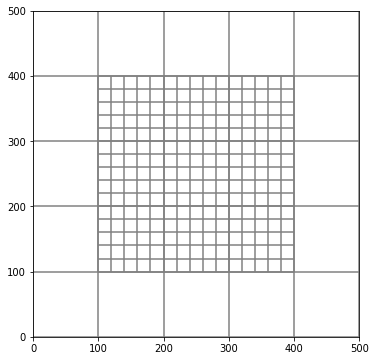

In [15]:
# plot the child and parent grids, which can be
# done easily using the flopy modelgrid objects
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mgc.plot(ax=ax)
mgp.plot(ax=ax)

## Building a Simple MODFLOW 6 Model

 For this example, we reproduce the simple model shown on the front page of the flopy GitHub repository.  In this adaptation, we insert a finer, locally refined grid in the middle of the domain, but we tightly couple the parent and child models.

In [16]:
# set up the MODFLOW 6 simulation
ws = workspace
simname = 'lgr'
pname = "parent"
cname = "child"
sim = flopy.mf6.MFSimulation(sim_name=simname, sim_ws=ws, exe_name='mf6')
tdis = flopy.mf6.ModflowTdis(sim)

# Because we will use the xt3d option for coupling the models
# we need use to the asymmetric BICGSTAB linear solver
ims = flopy.mf6.ModflowIms(sim, linear_acceleration="BICGSTAB")

# retrieve the exchange data from the lgr object
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)

# When creating the exchange, which couples the child and parent
# models, use the xt3d option, which is an alternative to the
# ghost-node correction.  This xt3d option was added as a new
# capability in MODFLOW version 6.3.0.
exg = flopy.mf6.ModflowGwfgwf(sim, exgtype="GWF6-GWF6", 
                              xt3d=True,
                              auxiliary=["angldegx", "cdist"],
                              exgmnamea=pname, exgmnameb=cname,
                              nexg=nexg, exchangedata=exchangedata)

# Set up the parent model and use the lgr.parent object to
# help provide the necessary information.
lgrp = lgr.parent
gwfp = flopy.mf6.ModflowGwf(sim, modelname=pname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfp, **lgrp.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfp)
npf = flopy.mf6.ModflowGwfnpf(gwfp, save_specific_discharge=True)
chdspd = [
    [(0, 0, 0), 1.],
    [(0, lgrp.nrow - 1, lgrp.ncol - 1), 0.]
]
chd = flopy.mf6.ModflowGwfchd(gwfp, stress_period_data=chdspd)
oc = flopy.mf6.ModflowGwfoc(gwfp,
                            budget_filerecord=pname + '.bud',
                            head_filerecord=pname + '.hds',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# Set up the child model and use the lgr.child object to
# help provide the necessary information.
lgrc = lgr.child
gwfc = flopy.mf6.ModflowGwf(sim, modelname=cname, save_flows=True)
dis = flopy.mf6.ModflowGwfdis(gwfc, **lgrc.get_gridprops_dis6())
ic = flopy.mf6.ModflowGwfic(gwfc)
npf = flopy.mf6.ModflowGwfnpf(gwfc, save_specific_discharge=True)
oc = flopy.mf6.ModflowGwfoc(gwfc,
                            budget_filerecord=cname + '.bud',
                            head_filerecord=cname + '.hds',
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

sim.write_simulation()
success, buff = sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing package lgr.gwfgwf...
  writing model parent...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package chd_0...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2 based on size of stress_period_data
    writing package oc...
  writing model child...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
FloPy is using the following executable to run the model: /Users/langevin/langevin/bin/mac/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on In

In [17]:
# load and store the head arrays from the parent and child models
head = [gwfp.output.head().get_data(), gwfc.output.head().get_data()]

# load and store the specific discharge results for the parent and child models
bud = gwfp.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
spdisp = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfp)
bud = gwfc.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
spdisc = flopy.utils.postprocessing.get_specific_discharge(spdis, gwfc)

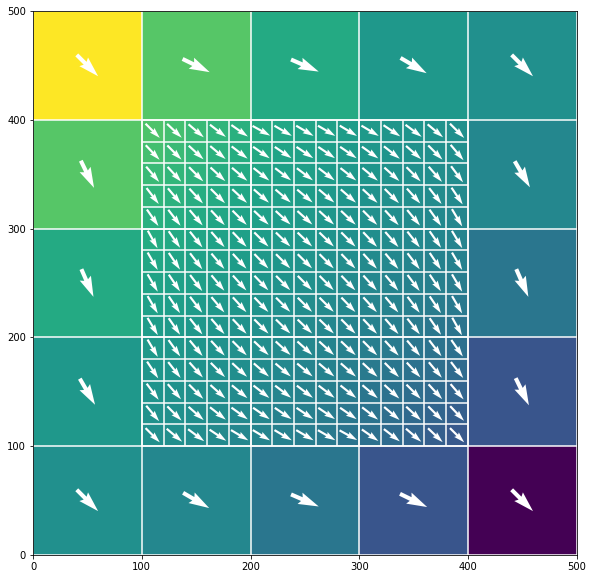

In [18]:
# plot the results from both the parent and child models
# on the same figure
f = plt.figure(figsize=(10, 10))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmvp = flopy.plot.PlotMapView(gwfp, ax=ax)
pmvc = flopy.plot.PlotMapView(gwfc, ax=ax, extent=pmvp.extent)

pmvp.plot_array(head[0], vmin=0., vmax=1.)
pmvc.plot_array(head[1], vmin=0., vmax=1.)

pmvp.plot_grid(colors="white")
pmvc.plot_grid(colors="white")

pmvp.plot_vector(spdisp[0], spdisp[1], normalize=True, color="white")
pmvc.plot_vector(spdisc[0], spdisc[1], normalize=True, color="white")